In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from pprint import pprint


from datetime import datetime

# I have a config file on my computer, you are going to have to add your own with the api key
from config import omdb_key

netflix_data = "resources/netflix daily top 10.csv"
netflix_titles_source = "resources/netflix_titles.csv"
netflix = pd.read_csv(netflix_data)
netflix_titles = pd.read_csv(netflix_titles_source)

In [2]:
netflix

,As of,Rank,Year to Date Rank,Last Week Rank,Title,Type,Netflix Exclusive,Netflix Release Date,Days In Top 10,Viewership Score
0,2020-04-01,1,1,1,"Tiger King: Murder, Mayhem …",TV Show,Yes,"Mar 20, 2020",9,90
1,2020-04-01,2,2,-,Ozark,TV Show,Yes,"Jul 21, 2017",5,45
2,2020-04-01,3,3,2,All American,TV Show,NaN,"Mar 28, 2019",9,76
3,2020-04-01,4,4,-,Blood Father,Movie,NaN,"Mar 26, 2020",5,30
4,2020-04-01,5,5,4,The Platform,Movie,Yes,"Mar 20, 2020",9,55
...,...,...,...,...,...,...,...,...,...,...
7095,2022-03-11,6,5,1,Worst Roommate Ever,TV Show,Yes,"Mar 1, 2022",10,81
7096,2022-03-11,7,7,2,Vikings: Valhalla,TV Show,Yes,"Feb 25, 2022",14,100
7097,2022-03-11,8,8,-,Shooter,Movie,NaN,"Aug 1, 2014",3,7
7098,2022-03-11,9,9,7,Shrek 2,Movie,NaN,"Mar 1, 2022",10,33


# Cleaning up Outliers and Exploring Some Scatterplots

This section is just to remove outliers, namely "Cocomelon" and looking at a couple of scatterplots trying to gleam any information I could out of it

In [3]:

titles_unclean = netflix["Title"].unique()
titles = []
average_ranking = []
viewer_score = []

# remove cocomelon since it is such an extreme outlier
for title in titles_unclean:
    if title != "Cocomelon":
        titles.append(title)

for title in titles:
    average_ranking.append(netflix["Rank"].loc[netflix["Title"] == title].mean())
    viewer_score.append(netflix["Viewership Score"].loc[netflix["Title"] == title].mean())

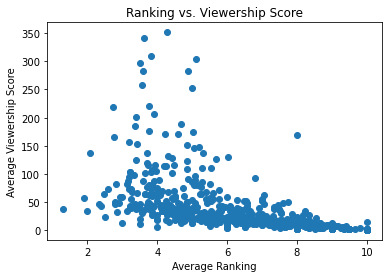

In [4]:
plt.scatter(average_ranking, viewer_score)
plt.xlabel("Average Ranking")
plt.ylabel("Average Viewership Score")
plt.title("Ranking vs. Viewership Score")
plt.show()

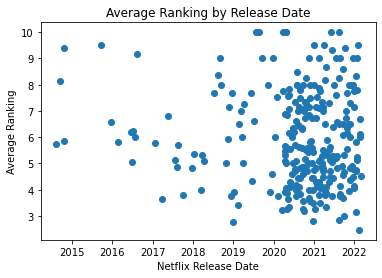

In [5]:
# Get a list of all of the dates in the dataset

date_raw = netflix["Netflix Release Date"].unique()
dates = []

# Convert the dates to datetime objects so that we can sort them in order
for date in date_raw:
    dates.append(datetime.strptime(date, '%b %d, %Y'))

dates.sort()

#remove the first one, since it is an outlier
dates.pop(0)
    
# Set up an empty list that we can add to as we go through the loop
average_ranking = []

# Note that the list dates contains a list of datetime objects, we use .strftime to convert it back
# to the format that the dataset uses
for date in dates:
    average_ranking.append(netflix["Rank"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].mean())
    
plt.scatter(dates, average_ranking)
plt.xlabel("Netflix Release Date")
plt.ylabel("Average Ranking")
plt.title("Average Ranking by Release Date")

plt.show()

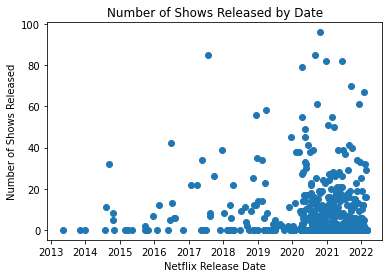

In [6]:
# This counts how many titles were released on each day

# I just realized that this counts how many times entries with that release date appear
# So titles that appear multiple times in the dataset count multiple times, so this data is a bit useless

released = []

for date in dates:
    released.append(netflix["Title"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].count())
    
plt.scatter(dates, released)
plt.xlabel("Netflix Release Date")
plt.ylabel("Number of Shows Released")
plt.title("Number of Shows Released by Date")
plt.show()

In [7]:
# I was trying to split the dates by month and get total rankings for each month
# It didn't work, don't know why

jan_dates = []
feb_dates = []
mar_dates = []
apr_dates = []
may_dates = []
jun_dates = []
jul_dates = []
aug_dates = []
sep_dates = []
oct_dates = []
nov_dates = []
dec_dates = []

for date in dates:
    if date.strftime("%m") == "01":
        jan_dates.append(date)
    elif date.strftime("%m") == "02":
        feb_dates.append(date)
    elif date.strftime("%m") == "03":
        mar_dates.append(date)
    elif date.strftime("%m") == "04":
        apr_dates.append(date)
    elif date.strftime("%m") == "05":
        may_dates.append(date)
    elif date.strftime("%m") == "06":
        jun_dates.append(date)
    elif date.strftime("%m") == "07":
        jul_dates.append(date)
    elif date.strftime("%m") == "08":
        aug_dates.append(date)
    elif date.strftime("%m") == "09":
        sep_dates.append(date)
    elif date.strftime("%m") == "10":
        oct_dates.append(date)
    elif date.strftime("%m") == "11":
        nov_dates.append(date)
    elif date.strftime("%m") == "12":
        dec_dates.append(date)

month_list = [jan_dates, feb_dates,mar_dates,apr_dates,may_dates,jun_dates,jul_dates,aug_dates,sep_dates,oct_dates,nov_dates,dec_dates]

months = ["January","Feburary","March","April","May","June","July","August","September","October","November","December"]
monthly_rankings = []

for month in month_list:
    temp_rankings = []
    for date in month:
        temp_rankings.append(netflix["Rank"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].mean())
        
    monthly_rankings.append(sum(temp_rankings) / len(temp_rankings))
    
monthly_rankings

    
netflix.loc[netflix["Netflix Release Date"] == dec_dates[1].strftime('%b %d, %Y')].mean()
dec_dates[1].strftime('%b %d, %Y')


'Dec 01, 2017'

# Using the OMDB API to Get More Information

Here I am using the OMDB API to get more information like show rating and online review scores

In [10]:
# Here we use the omdb API to get some extra info on all of our titles, just saving the json file to a dictionary for now

titles = netflix["Title"].unique()
json_data = {}
url = "http://www.omdbapi.com/?t="
api_key = "&apikey=" + omdb_key

for title in titles:
    response = requests.get(url + title + api_key)
    data = response.json()
    json_data[title] = data



In [ ]:
# 72 titles were not reconized by the API, here is a list of all of them 
# Its short enough that we could enter it in manually if we really wanted to
titles_not_found = []

for title in titles:
    if json_data[title]['Response'] == 'False':
        titles_not_found.append(title)
        
titles_not_found

In [ ]:
# The goal here is to turn the json data we got from the api into a dataframe and save it as a csv file, then merge it
# So I first find the all the different pieces of data that json_data contains
columns = []

for title in titles:
    for entry in json_data[title]:
        if entry not in columns:
            columns.append(entry)
columns

In [ ]:
# Now that I know all the different pieces of data I can make a dictionary that I'll turn into a dataframe

omdb_data_dict = {
 'Title': [],
 'Response': [],
 'Error': [],
 'OMDB_Title': [],
 'Year' : [],
 'Rated' : [],
 'Released' : [],
 'Runtime' : [],
 'Genre' : [],
 'Director' : [],
 'Writer' : [],
 'Actors' : [],
 'Plot' : [],
 'Language' : [],
 'Country' : [],
 'Awards' : [],
 'Poster' : [],
 'Ratings' : [],
 'Metascore' : [],
 'imdbRating' : [],
 'imdbVotes' : [],
 'imdbID' : [],
 'Type' : [],
 'totalSeasons' : [],
 'DVD' : [],
 'BoxOffice': [],
 'Production': [],
 'Website': []
}

# loop through all the titles that we have
for title in titles:
    # Then loop through all the keys in the dictionary that we're trying to create
    for key in omdb_data_dict:
        
        # If the title in json_data doesn't have the appropriate column then I want to add N/A as a string so the lists 
        # in the dictionary are all the same length so it can all be put into a dataframe
        # I use N/A since thats what the api uses for missing data so its consistent
        try:
            omdb_data_dict[key].append(json_data[title][key])
        except:
            
            # I don't want to fill the title column with N/A since I want to merg on that later 
            if key == "Title":
                omdb_data_dict[key].append(title)                
            else:
                omdb_data_dict[key].append("N/A")
                
        
            
# With the dictionary complete let's turn it into a dataframe

omdb_df = pd.DataFrame(omdb_data_dict)
omdb_df.to_csv("resources/netflix-daily-top-10-omdb-data.csv")
omdb_df

# Here I'm Trying to Make Line Graphs

This section I'm trying to figure out a way to make line graphs to show trends in the data

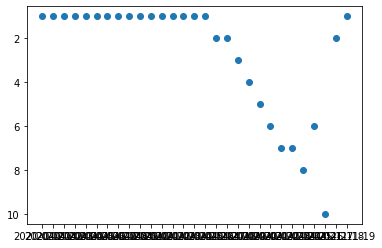

In [8]:
# the first entry in titles is for Tiger King, so I just do this instead of writing it's name over and over
tiger_king_times = netflix["As of"].loc[netflix["Title"] == titles[0]]
tiger_king_datetime = []
tiger_king_rank = netflix["Rank"].loc[netflix["Title"] == titles[0]]

# I get a list times and convert them to datetime objects
for time in tiger_king_times:
    tiger_king_datetime.append(datetime.strptime(time, '%Y-%m-%d'))
    
scatter = plt.scatter(x=tiger_king_times,y=tiger_king_rank)
ax = scatter.axes

# Invert axis so that 1 is on top
ax.invert_yaxis()

tiger_king_rank_and_date = netflix[["As of","Rank"]].loc[netflix["Title"] == titles[0]]

In [47]:
# This code works, but it takes a really long time to complete (like 10+ minutes), 
# I need to streamline it a bit to make it faster or put it in a dataframe and save it as a csv

# Here I'm trying to get a list of all the unique dates and turn them into datetime objects so I can sort them
# The intent here is to build a dataframe with all the dates in a single column and then rankings on that date for an individual show in another 
# You can probably give it a column for every show to make graphing a shows change in position over time easier
as_of_dates = netflix["As of"].unique()
as_of_datetime = []

for date in as_of_dates:
    as_of_datetime.append(datetime.strptime(date, '%Y-%m-%d'))
as_of_datetime.sort()
as_of_datetime

# Make a dictionary with the 'as of' dates and every title that appears in the dataset as a key,
# and its value being a list of that title's rank on that day

# We start first with a dictionary of empty lists
ranking_trend = {"As of": []}
for title in netflix["Title"].unique():
    ranking_trend[title] = []
ranking_trend

# We loop through every date
for date in as_of_datetime:
    
    # Add that date to our ranking_trend dictionary
    ranking_trend["As of"].append(date)
    
    # Define this as the daily top 10 on that date
    daily_top_10 = netflix.loc[netflix["As of"] == date.strftime('%Y-%m-%d')]
    
    # Loop through each title that we have
    for title in netflix["Title"].unique():
        
        is_in_top_10 = False
        # Check if that title is in today's daily top 10 by going through each line
        # Then, if found, append its rank
        for i in range(10):
            
            top_10_line = daily_top_10.iloc[i]
            if top_10_line["Title"] == title:
                ranking_trend[title].append(top_10_line["Rank"])
                
                # If we found it in the top ten then set this variable to true
                is_in_top_10 = True
        
        # If it wasn't in the top 10 then we simply add "None" to the list
        if is_in_top_10 == False:
            ranking_trend[title].append(None)
    print(f"{date} is done")

2020-04-01 00:00:00 is done
2020-04-02 00:00:00 is done
2020-04-03 00:00:00 is done
2020-04-04 00:00:00 is done
2020-04-05 00:00:00 is done
2020-04-06 00:00:00 is done
2020-04-07 00:00:00 is done
2020-04-08 00:00:00 is done
2020-04-09 00:00:00 is done
2020-04-10 00:00:00 is done
2020-04-11 00:00:00 is done
2020-04-12 00:00:00 is done
2020-04-13 00:00:00 is done
2020-04-14 00:00:00 is done
2020-04-15 00:00:00 is done
2020-04-16 00:00:00 is done
2020-04-17 00:00:00 is done
2020-04-18 00:00:00 is done
2020-04-19 00:00:00 is done
2020-04-20 00:00:00 is done
2020-04-21 00:00:00 is done
2020-04-22 00:00:00 is done
2020-04-23 00:00:00 is done
2020-04-24 00:00:00 is done
2020-04-25 00:00:00 is done
2020-04-26 00:00:00 is done
2020-04-27 00:00:00 is done
2020-04-28 00:00:00 is done
2020-04-29 00:00:00 is done
2020-04-30 00:00:00 is done
2020-05-01 00:00:00 is done
2020-05-02 00:00:00 is done
2020-05-03 00:00:00 is done
2020-05-04 00:00:00 is done
2020-05-05 00:00:00 is done
2020-05-06 00:00:00 

2021-01-19 00:00:00 is done
2021-01-20 00:00:00 is done
2021-01-21 00:00:00 is done
2021-01-22 00:00:00 is done
2021-01-23 00:00:00 is done
2021-01-24 00:00:00 is done
2021-01-25 00:00:00 is done
2021-01-26 00:00:00 is done
2021-01-27 00:00:00 is done
2021-01-28 00:00:00 is done
2021-01-29 00:00:00 is done
2021-01-30 00:00:00 is done
2021-01-31 00:00:00 is done
2021-02-01 00:00:00 is done
2021-02-02 00:00:00 is done
2021-02-03 00:00:00 is done
2021-02-04 00:00:00 is done
2021-02-05 00:00:00 is done
2021-02-06 00:00:00 is done
2021-02-07 00:00:00 is done
2021-02-08 00:00:00 is done
2021-02-09 00:00:00 is done
2021-02-10 00:00:00 is done
2021-02-11 00:00:00 is done
2021-02-12 00:00:00 is done
2021-02-13 00:00:00 is done
2021-02-14 00:00:00 is done
2021-02-15 00:00:00 is done
2021-02-16 00:00:00 is done
2021-02-17 00:00:00 is done
2021-02-18 00:00:00 is done
2021-02-19 00:00:00 is done
2021-02-20 00:00:00 is done
2021-02-21 00:00:00 is done
2021-02-22 00:00:00 is done
2021-02-23 00:00:00 

2021-11-08 00:00:00 is done
2021-11-09 00:00:00 is done
2021-11-10 00:00:00 is done
2021-11-11 00:00:00 is done
2021-11-12 00:00:00 is done
2021-11-13 00:00:00 is done
2021-11-14 00:00:00 is done
2021-11-15 00:00:00 is done
2021-11-16 00:00:00 is done
2021-11-17 00:00:00 is done
2021-11-18 00:00:00 is done
2021-11-19 00:00:00 is done
2021-11-20 00:00:00 is done
2021-11-21 00:00:00 is done
2021-11-22 00:00:00 is done
2021-11-23 00:00:00 is done
2021-11-24 00:00:00 is done
2021-11-25 00:00:00 is done
2021-11-26 00:00:00 is done
2021-11-27 00:00:00 is done
2021-11-28 00:00:00 is done
2021-11-29 00:00:00 is done
2021-11-30 00:00:00 is done
2021-12-01 00:00:00 is done
2021-12-02 00:00:00 is done
2021-12-03 00:00:00 is done
2021-12-04 00:00:00 is done
2021-12-05 00:00:00 is done
2021-12-06 00:00:00 is done
2021-12-07 00:00:00 is done
2021-12-08 00:00:00 is done
2021-12-09 00:00:00 is done
2021-12-10 00:00:00 is done
2021-12-11 00:00:00 is done
2021-12-12 00:00:00 is done
2021-12-13 00:00:00 

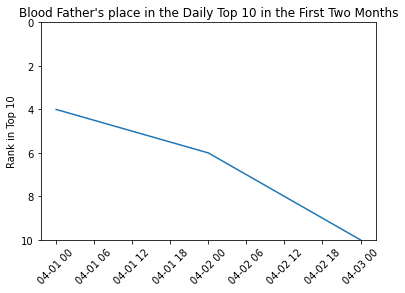

In [106]:
title = titles[3]

time_period = ranking_trend["As of"]
show_rank = ranking_trend[title]
plot = plt.plot(time_period, show_rank)
plt.title(f"{title}'s place in the Daily Top 10 in the First Two Months")
plt.xticks(rotation = 45)
plt.ylabel("Rank in Top 10")
plt.ylim(10, 0)
plt.show()

In [65]:
# Look at the top 10 list on 4/21/2020
netflix.loc[netflix["As of"] == "2020-04-21"]

# Look at all the shows that were at number 1
netflix.loc[netflix["Rank"] == 1]

# Get the list of unique titles
titles_top_10 = netflix["Title"].unique()

# We are going to get a list of days those titles were in the top 10, we start with an empty list
max_days_in_top_10 = []

# Loop through the titles and get the max number of days it was in the top 10 (This would be the total number of days it shows up)
for title in titles_top_10:
    max_days_in_top_10.append(netflix["Days In Top 10"].loc[netflix["Title"] == title].max())

max_days_in_top_10

# Turn that into a dataframe
max_days_in_top_10_df = pd.DataFrame({
    "Title":titles_top_10,
    "Max Days In Top 10":max_days_in_top_10
})

# Look at Tiger King's ranking
max_days_in_top_10_df.loc[max_days_in_top_10_df["Title"] == "Tiger King: Murder, Mayhem …"]

,Title,Max Days In Top 10
0,"Tiger King: Murder, Mayhem …",37


# Some Extra Fiddling with netfix-titles

In [16]:
# This code finds the list of genres mentioned in the netflix-titles csv file


genres = []

# The listed_in column is a string containing the netflix catagories it was in seperated by commas, so they get split up and added to the genres list
netflix_titles["listed_in"].unique()

for listed in netflix_titles["listed_in"].unique():
    for element in listed.split(","):
        genres.append(element)

# Then we don't want repeats       
genres_cleaned = []
for element in genres:
    if element not in genres_cleaned:
        genres_cleaned.append(element.strip())


genres_cleaned        


['Documentaries',
 'International TV Shows',
 'TV Dramas',
 'TV Mysteries',
 'Crime TV Shows',
 'International TV Shows',
 'TV Action & Adventure',
 'Docuseries',
 'Reality TV',
 'Romantic TV Shows',
 'TV Comedies',
 'TV Horror',
 'TV Mysteries',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'British TV Shows',
 'Reality TV',
 'Comedies',
 'Dramas',
 'Docuseries',
 'International TV Shows',
 'International Movies',
 'Comedies',
 'Crime TV Shows',
 'Docuseries',
 'TV Dramas',
 'International Movies',
 'Spanish-Language TV Shows',
 'TV Dramas',
 'Thrillers',
 'Spanish-Language TV Shows',
 'TV Action & Adventure',
 'TV Action & Adventure',
 'TV Dramas',
 'International Movies',
 'International Movies',
 'Romantic Movies',
 'International TV Shows',
 'Reality TV',
 'International Movies',
 'Music & Musicals',
 'Horror Movies',
 'Sci-Fi & Fantasy',
 'International TV Shows',
 'TV Comedies',
 'TV Dramas',
 'TV Thrillers',
 "Kids' TV",
 'Internationa